In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import porepy as pp

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


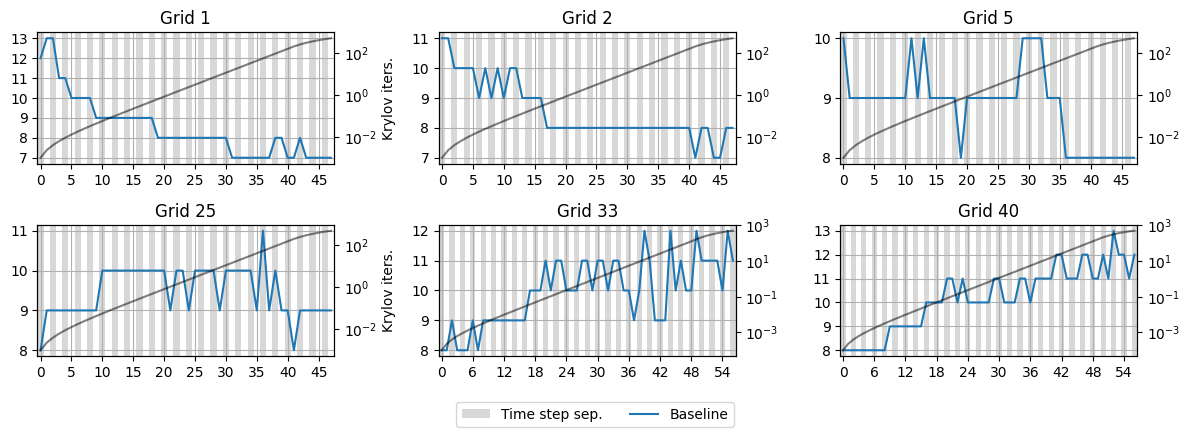

In [14]:
grids = [
    1,
    2,
    5,
    25,
    33,
    40,
]

sol = [3,]

data = {}
names = {}
for i, g in enumerate(grids):
    data[i] = []
    for j, s in enumerate(sol):
        data[i].append(load_data(f"../stats/stats_thermal_geonofracx{g}_sol{s}.json"))
        names[i] = f"Grid {g}"


shape = [2, 3]
figsize = (12, 4)


def render_element(i, data):
    color_time_steps(data[0], fill=True, legend=True)
    # color_converged_reason(data[0], legend=True)
    plt.gca().grid(True)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(data[0]), label='Baseline')
    # plt.plot(get_gmres_iterations(data[1]), label='Thermal FS', linestyle='--')
    plt.twinx()
    DAY = 3600 * 24
    plt.plot(np.cumsum(get_time_steps(data[0])) / DAY , color='black', alpha=0.5, label='Time')
    plt.yscale('log')


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

In [15]:
from collections import defaultdict
import pandas as pd

table = defaultdict(lambda: [])

NDIGITS = 1

for g in grids:
    stats_name = f"stats_thermal_geonofracx{g}_sol3.json"
    entry = load_data(f"../stats/{stats_name}")
    dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
    total_dofs = dofs_info["total dofs"]
    table["Total DoFs"].append(int(total_dofs))

    # if g in [1, 2, 5]:
    #     direct = load_data(f"../stats/stats_geo0x{g}_sol{21}_ph{1}_bb{2}_fr{1}.json")
    #     table["GMRES dir."].append(round(np.mean(get_gmres_iterations(direct)), NDIGITS))
    # else:
    #     table["GMRES dir."].append('-')

    table["GMRES AMG"].append(round(np.mean(get_gmres_iterations(entry)), NDIGITS))
    table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))
    converged_reason = get_petsc_converged_reason(entry)
    # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table).T
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = 'Total DoFs'
table

Total DoFs,1384.0,5432.0,33744.0,832664.0,1451776.0,2128664.0
GMRES AMG,8.5,8.5,8.9,9.5,9.9,10.2
Newton iters.,1.0,1.0,1.0,1.0,1.0,1.0


In [6]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_nofrac import make_model
import porepy as pp

model = make_model(
    {
        "geometry": "nofrac",
        "grid_refinement": 5,
        "solver": 3,
        "save_matrix": False,
        "steady_state": False,
        "initial_state": "/home/porepy/volume/nrec_fhm/stats_thermal_geonofracx5_sol3_endstate_1738674820968.npy",
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.00e+00, Dt: 1.00e-03 (days)
Temperature: 393.00, 393.00
sticking: 0, sliding: 0, open: 0


In [5]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    # '../stats/stats_thermal_geonofracx1_sol4_1738425817582.json'
    # load_data(),
    load_data(f"../stats/{model.simulation_name()}.json"),
    30,
)

IsADirectoryError: [Errno 21] Is a directory: '../matrices'

In [5]:
model.linear_system = mat, rhs
model.bmat.mat = mat
model.equation_system.set_variable_values(state, time_step_index=0)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.ad_time_step.set_value(dt)
model.time_manager.dt = dt
model.discretize()

NameError: name 'mat' is not defined

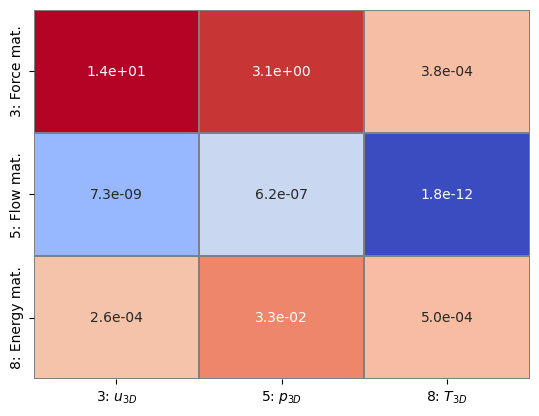

In [7]:
J = model.bmat[:]
J.plot_max()

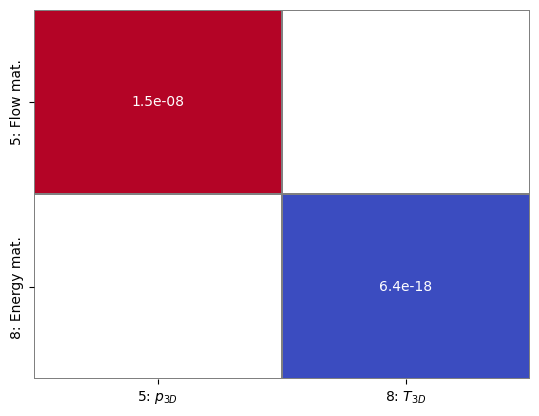

In [8]:
from fixed_stress import (
    get_fixed_stress_stabilization,
    make_fs_analytical,
    make_fs_thermal,
)
from mat_utils import *
from block_matrix import *


def make_stab(bmat: BlockMatrixStorage, keep: list[int], elim: list[int]):
    stab = bmat[keep].empty_container()
    inv_ = inv_block_diag(bmat[elim].mat, nd=model.nd)
    stab.mat -= bmat[keep, elim].mat @ inv_ @ bmat[elim, keep].mat
    return stab


# elim = [0, 1, 2, 3, 4]
# keep = [5, 6, 8, 9]
p = [5]
T = [8]
elim = [3]
keep = p + T
# stab1 = make_stab(J, elim=elim, keep=keep)
# stab1.set_zeros(p, p)
# stab1.set_zeros(p, T)
# stab1.set_zeros(T, p)
# stab1.set_zeros(T, T)

stab1 = make_fs_thermal(
    model,
    J,
    groups=keep,
    p_mat_group=5,
    p_frac_group=-1,
    t_mat_group=8,
    t_frac_group=-1,
)
stab1.plot_max()

S = J[keep].copy()
S.mat += stab1.mat

ksp_type fgmres
ksp_pc_side right
ksp_rtol 1e-10
ksp_max_it 120
ksp_gmres_cgs_refinement_type refine_ifneeded
ksp_gmres_classicalgramschmidt True
pc_type fieldsplit
pc_fieldsplit_type schur
pc_fieldsplit_schur_precondition user
pc_fieldsplit_schur_fact_type upper
fieldsplit_3-4_ksp_type gmres
fieldsplit_3-4_pc_type hypre
fieldsplit_5-6-7-8-9-10_ksp_type preonly
fieldsplit_3-4_ksp_rtol 0.01
fieldsplit_3-4_ksp_pc_side right
fieldsplit_3-4_pc_hypre_type boomeramg
fieldsplit_3-4_pc_hypre_boomeramg_strong_threshold 0.6
fieldsplit_3-4_pc_hypre_boomeramg_P_max 1
fieldsplit_3-4_pc_hypre_boomeramg_max_iter 1
fieldsplit_3-4_pc_hypre_boomeramg_cycle_type W
fieldsplit_5-6-7-8-9-10_pc_type composite
fieldsplit_5-6-7-8-9-10_pc_composite_type multiplicative
fieldsplit_5-6-7-8-9-10_pc_composite_pcs fieldsplit,ksp
fieldsplit_5-6-7-8-9-10_sub_0_pc_fieldsplit_type additive
fieldsplit_5-6-7-8-9-10_sub_1_ksp_ksp_pc_side right
fieldsplit_5-6-7-8-9-10_sub_1_ksp_ksp_rtol 0.01
fieldsplit_5-6-7-8-9-10_sub_1_ksp

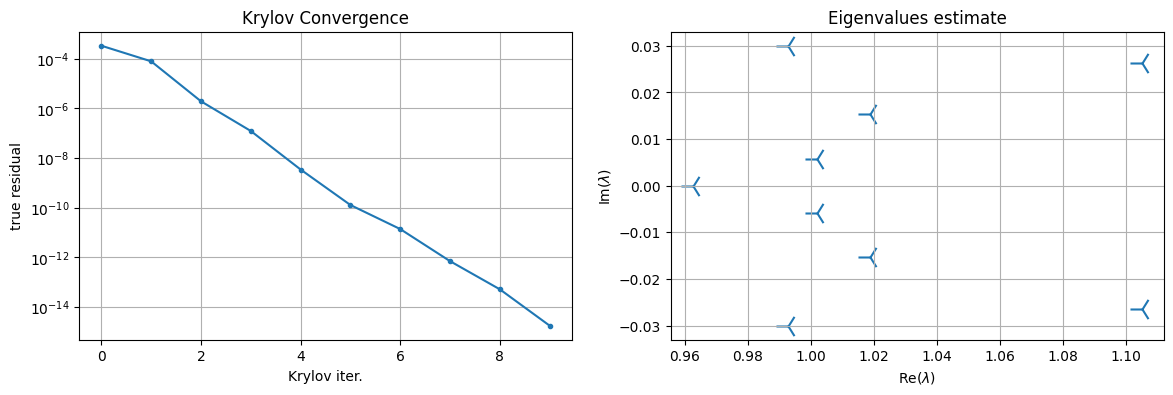

In [13]:
from fixed_stress import make_fs_thermal
from full_petsc_solver import *

self = model
contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]

scheme = LinearTransformedScheme(
    # right_transformations=[lambda bmat: self.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            "ksp_type": "fgmres",
            # 'ksp_type': 'richardson',
            # 'ksp_pc_side': 'left',
            # "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=mech,
            subsolver_options={
                'ksp_type': 'gmres',
                'ksp_rtol': 1e-2,
                'ksp_pc_side': 'right',
                # 'ksp_monitor': None,
                # # old
                "pc_type": "hypre",
                "pc_hypre_type": "boomeramg",
                "pc_hypre_boomeramg_strong_threshold": 0.6,
                # not sure:
                "pc_hypre_boomeramg_P_max": 1,
                'pc_hypre_boomeramg_max_iter': 1, 
                'pc_hypre_boomeramg_cycle_type': 'W',
            },
            tmp_options={
                # 'ksp_type': 'gmres',
                # 'ksp_rtol': 1e-3,
                # 'ksp_pc_side': 'right',
                # 'ksp_monitor': None,
            },
            block_size=self.nd,
            invert=lambda bmat: csr_to_petsc(
                make_fs_thermal(
                    self,
                    bmat,
                    p_mat_group=5,
                    p_frac_group=-1,
                    t_mat_group=8,
                    t_frac_group=-1,
                    groups=flow + temp,
                ).mat * 1,
                bsize=1,
            ),
            complement=PetscCPRScheme(
                groups=flow + temp,
                pressure_groups=flow,
                pressure_options={
                    # 'ksp_type': 'gmres',
                    # 'ksp_rtol': 1e-8,
                    # 'ksp_pc_side': 'right',
                    # 'ksp_monitor': None,
                    "pc_type": "hypre",
                    "pc_hypre_type": "boomeramg",
                },
                others_options={
                    "ksp_type": "preonly",
                    "pc_type": "none",
                },
                cpr_options={
                    "pc_composite_pcs": "fieldsplit,ksp",
                    'sub_1_ksp_ksp_pc_side': 'right',
                    'sub_1_ksp_ksp_rtol': 1e-2,
                    'sub_1_ksp_pc_type': 'hypre',
                    'sub_1_ksp_pc_hypre_type': "Euclid",
                    'sub_1_ksp_ksp_monitor': None,
                    'sub_1_ksp_ksp_max_it': 120,
                    # 
                    # "pc_composite_pcs": "fieldsplit,ilu",
                    # "pc_composite_pcs": "fieldsplit,hypre",
                    # 'sub_1_pc_hypre_type': 'Euclid',
                },
            ),
        ),
    ),
)

ksp = solve_petsc_3(J, rhs, scheme, ksp_view=True, options_view=True, return_data=True)

In [101]:
ksp.ksp